In [1]:
import os 
import torch
import torchvision
from torchvision.datasets.utils import download_url
import tarfile

In [2]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"


In [3]:
download_url(dataset_url,'.')

In [4]:
with tarfile.open('cifar10.tgz','r:gz') as tar:
  tar.extractall(path='./data')

In [5]:
data_dir='./data/cifar10/'

In [6]:
import os 
os.listdir(data_dir)

['train', 'test']

In [7]:
classes=os.listdir(data_dir+'/train')
classes

['ship',
 'horse',
 'dog',
 'bird',
 'cat',
 'deer',
 'truck',
 'airplane',
 'frog',
 'automobile']

In [8]:
from torchvision.datasets import ImageFolder
import numpy as np
import torchvision.transforms as tt

In [9]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))


In [10]:
train_tfms=tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), tt.ToTensor(),
                       tt.Normalize(*stats,inplace=True)
                       
                        ])
valid_tfms=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

In [11]:
train_ds=ImageFolder(data_dir+'./train',transform=train_tfms)
valid_ds=ImageFolder(data_dir+'./test',transform=train_tfms)

In [12]:
from torch.utils.data import DataLoader

In [13]:
bs=256



In [14]:
train_dl=DataLoader(train_ds,bs,shuffle=True,num_workers=2,pin_memory=True)
valid_dl=DataLoader(valid_ds,bs,num_workers=2)

In [15]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [16]:
def show_batch(dl):
  for xb,yb in dl:
    fig,ax=plt.subplots(figsize=(16,16))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(xb[:100],10).permute(1,2,0))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


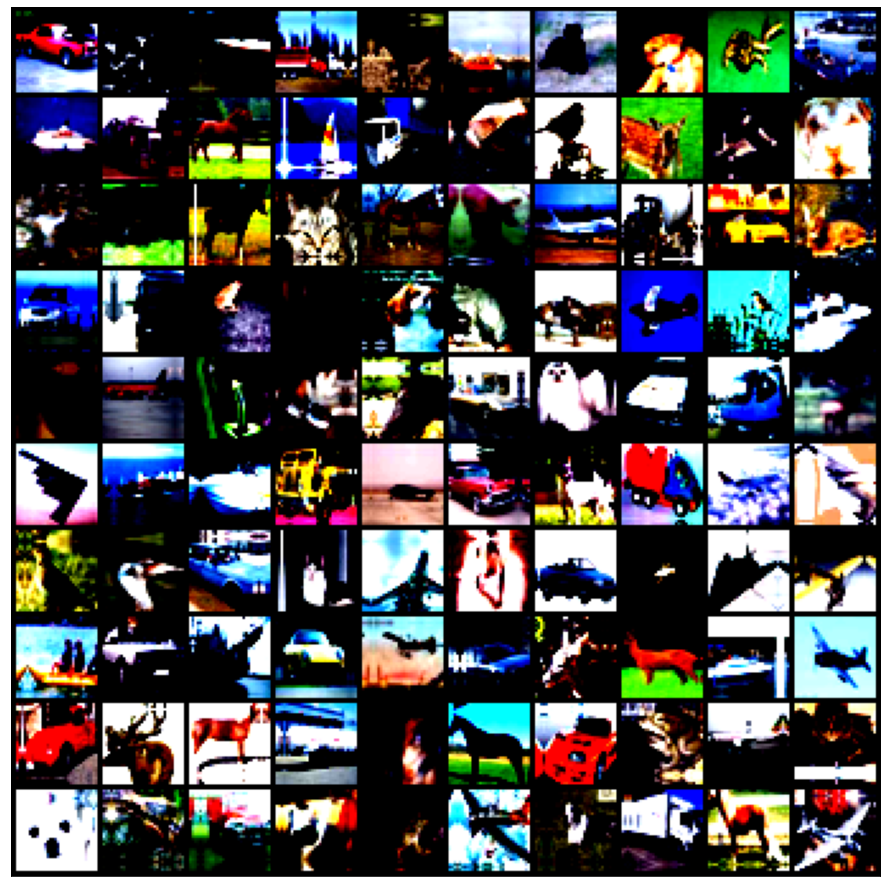

In [17]:
show_batch(train_dl)

# Resnet Model

In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
    self.relu1=nn.ReLU()
    self.conv2=nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
    self.relu2=nn.ReLU()

  def forward(self,x):
    out=self.conv1(x)
    out=self.relu1(out)
    out=self.conv2(out)
    return self.relu2(out+x)


In [20]:
simple_res=SimpleResidualBlock()

In [21]:
for xb,yb in train_dl:
  out=simple_res(xb)
  print(out.shape)
  break

torch.Size([256, 3, 32, 32])


In [22]:
def conv_block(input_channels,output_channels,pool=False):
  layers=[
          nn.Conv2d(input_channels,output_channels,kernel_size=3,padding=1) ,
          nn.BatchNorm2d(output_channels),
          nn.ReLU(inplace=True)]
  if pool :
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

In [23]:
class Resnet9(nn.Module):
  def __init__(self,in_channels,num_classes):
    super().__init__()
    self.conv1=conv_block(in_channels,64)
    self.conv2=conv_block(64,128,pool=True)
    self.res1=nn.Sequential(conv_block(128,128),conv_block(128,128))
    self.conv3=conv_block(128,256,pool=True)
    self.conv4=conv_block(256,512,pool=True)
    self.res2=nn.Sequential(conv_block(512,512),conv_block(512,512))
    self.classifier=nn.Sequential(
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(2048,512),
        nn.Linear(512,num_classes)
          )
  def forward(self,x):
    out=self.conv1(x)
    out=self.conv2(out)
    out=self.res1(out)+out
    out=self.conv3(out)
    out=self.conv4(out)
    out=self.res2(out)+out
    out=self.classifier(out)
    return out

In [24]:
model=Resnet9(3,10)

In [25]:
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [26]:
for images,labels in train_dl:
  out=model(images)
  print(images.shape,out.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([256, 3, 32, 32]) torch.Size([256, 10])


# GPU movement

In [27]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else :
    return torch.device('cpu')
    

In [28]:
device=get_default_device()
device

device(type='cuda')

In [29]:
def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [ to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

In [30]:
class Datadeviceloader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)
  def __len__ (self):
    return len(self.dl)

In [31]:
train_dl=Datadeviceloader(train_dl,device)
valid_dl=Datadeviceloader(valid_dl,device)

In [32]:
model=Resnet9(3,10)
to_device(model,device)

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# Training

In [33]:
def loss_batch(model,loss_fn,xb,yb,grad_clip=False,opt=None,metric=None):
  preds=model(xb)
  loss=loss_fn(preds,yb)
  
  
  if opt is not None:

      # Gradient clipping
    loss.backward()
    if grad_clip: 
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
    
    opt.step()
    opt.zero_grad()
  metric_result=None
  if metric is not None:
    metric_result=metric(preds,yb)
  return loss.item(),len(xb),metric_result

In [47]:
def evaluate(model,loss_fn,valid_dl,metric=None):

  with torch.no_grad():
    results=[loss_batch(model,loss_fn,xb,yb,metric=metric) for xb,yb in valid_dl] 
  

  losses,nums,metrics=zip(*results)

  total=np.sum(nums)
  avg_loss=np.sum(np.multiply(losses,nums)) /total

  if metric is not None :
    avg_metrics=np.sum(np.multiply(metrics,nums)) / total

  return avg_loss, total, avg_metrics


In [51]:
def accuracy(outputs, labels):
  _,preds=torch.max(outputs,dim=1)
  return torch.sum(preds==labels).item()/len(labels)


In [61]:

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [108]:
def fit_one_cycle(epochs,max_lr,model,train_dl,valid_dl,weight_decay,grad_clip,opt_fn=None,metric=None):
  torch.cuda.empty_cache()
  temp_loss=[]
  train_losses, valid_losses, val_metrics=[],[],[]
  lrs=[]

  

  if opt_fn is None : opt_fn=torch.optim.SGD()
  opt=opt_fn(model.parameters(),max_lr,weight_decay=weight_decay)


  sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dl))
    

  for epoch in range(0,epochs):
    model.train()
                # Record & update learning rate

    for xb,yb in train_dl:
      lrs.append(get_lr(opt))

      sched.step()

      train_loss_batch,_,_=loss_batch(model,loss_fn,xb,yb,grad_clip,opt,accuracy)

      temp_loss.append(train_loss_batch)

    train_loss=sum(temp_loss)/len(temp_loss)
    
    model.eval()
    results=evaluate(model,loss_fn,valid_dl,accuracy)

    val_loss,total,val_metric=results

    train_losses.append(train_loss)
    valid_losses.append(val_loss)
    val_metrics.append(val_metric)

      #progress
    if metric is None:
      print("Epoch : [{}/{}], Train Loss : {:.4f},Validation Loss : {:.4}".format(epoch+1,epochs,train_loss,val_loss))
    else:
      print("Epoch : [{}/{}], Train Loss : {:.4f}, Validation Loss : {:.4}, {} : {:.4f}".format(epoch+1,epochs,train_loss,val_loss,metric.__name__,val_metric))
  return  train_losses,valid_losses, val_metrics,lrs





    
    






In [109]:
model=Resnet9(3,10)
to_device(model,device)

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [110]:
loss_fn=F.cross_entropy
history = [evaluate(model,loss_fn, valid_dl,accuracy)]
history

[(2.662414488220215, 10000, 0.1043)]

In [111]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss_fn=F.cross_entropy

In [112]:
%%time 
history+=fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_fn=opt_func,metric=accuracy)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch : [1/8], Train Loss : 2.1467, Validation Loss : 1.709, accuracy : 0.4116
Epoch : [2/8], Train Loss : 1.7670, Validation Loss : 1.341, accuracy : 0.5251
Epoch : [3/8], Train Loss : 1.5053, Validation Loss : 0.9974, accuracy : 0.6572
Epoch : [4/8], Train Loss : 1.3223, Validation Loss : 0.9131, accuracy : 0.6959
Epoch : [5/8], Train Loss : 1.1863, Validation Loss : 0.6549, accuracy : 0.7699
Epoch : [6/8], Train Loss : 1.0753, Validation Loss : 0.5184, accuracy : 0.8233
Epoch : [7/8], Train Loss : 0.9776, Validation Loss : 0.4094, accuracy : 0.8627
Epoch : [8/8], Train Loss : 0.8914, Validation Loss : 0.3598, accuracy : 0.8769
CPU times: user 2min 22s, sys: 6.24 s, total: 2min 28s
Wall time: 5min 3s


In [ ]:
import matplotlib.pyplot as plt


In [119]:
history[3]

[0.4116, 0.5251, 0.6572, 0.6959, 0.7699, 0.8233, 0.8627, 0.8769]

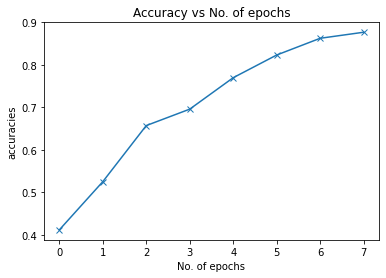

In [120]:
accuracies=history[3]
plt.plot(accuracies,"-x")
plt.xlabel('No. of epochs')
plt.ylabel("accuracies")
plt.title("Accuracy vs No. of epochs");

In [122]:
def plot_losses(train_losses,val_losses):
  plt.plot(train_losses,"-x")
  plt.plot(val_losses,"-o")
  plt.xlabel('No. of epochs')
  plt.ylabel("Losses")
  plt.legend(['Training','Validation'])

  plt.title("Losses vs No. of epochs");


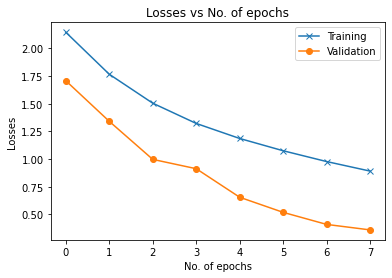

In [123]:
train_losses=history[1]
val_losses=history[2]
plot_losses(train_losses,val_losses)

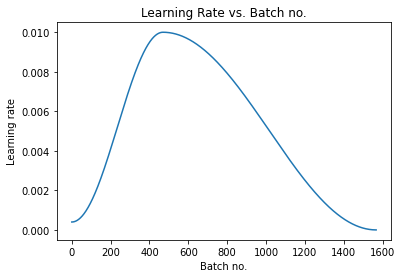

In [125]:
def plot_lrs(history):
    lrs = history[4]
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)
